# lab 7

# Supermodeling

## What is supermodeling

## Used Data Assimilation method

## Submodels

## Lorenz again

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

### Utilities

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

In [44]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed


def plot_models(models, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    for piece in models:
            ax.plot(piece[:, 0].flatten(), piece[:, 1].flatten(), piece[:, 2].flatten())
    plt.draw()
    plt.show()
    
def plot_model(model, figsize=(5,5)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    
    ax.plot(model[:, 0].flatten(), model[:, 1].flatten(), model[:, 2].flatten())
    plt.draw()
    plt.show()

    
# TODO 1
def calc_mean_lorenz(lorenz_models): 
#     raise NotImplementedError
    return np.array([np.mean(lorenz_models[:,i,:], axis=0) for i in range(lorenz_models.shape[1])])

# TODO 2
def calc_weighted_average_lorenz(lorenz_models, weights):
#     raise NotImplementedError
    return np.array([np.average(lorenz_models[:,i,:], axis=0, weights=weights) for i in range(lorenz_models.shape[1])])

def calc_mean_params(models_params):
    return np.mean(models_params, axis=0)

def calc_weighted_average_params(models_params, weights):
    return np.average(models_params, axis=0, weights=weights)

def lorenz_step(coords, t, parameters):
    rho, sigma, beta = parameters
    x, y, z = coords
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def generate_lorenz(x=1, y=1, z=1, sigma=10.0, rho=28.0, beta=8.0/3.0):
    start_coords = [x, y, z]
    parameters = [rho, sigma, beta]

    t = np.arange(0.0, 20.0, 0.02)

    return odeint(lorenz_step, start_coords, t, args=(parameters,))

### Sandbox

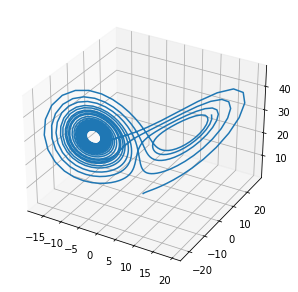

In [35]:
# generate and plot lorenz attractor
lorenz_attr = generate_lorenz()
plot_model(lorenz_attr)

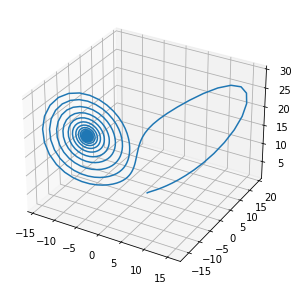

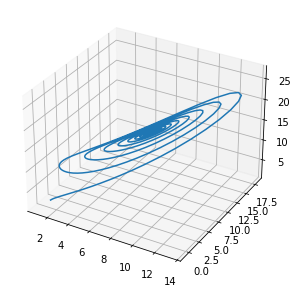

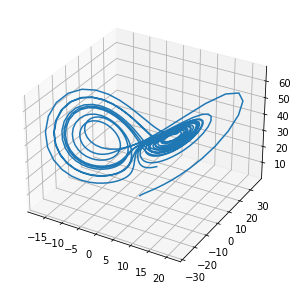

In [36]:
model_1_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 13.25,
    rho = 19.0,
    beta = 3.5
)

model_2_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 7.0,
    rho = 18.0,
    beta = 3.7
)


model_3_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 6.5,
    rho = 38.0,
    beta = 1.7
)

m1 = generate_lorenz(**model_1_params)
m2 = generate_lorenz(**model_2_params)
m3 = generate_lorenz(**model_3_params)


plot_model(m1)
plot_model(m2)
plot_model(m3)

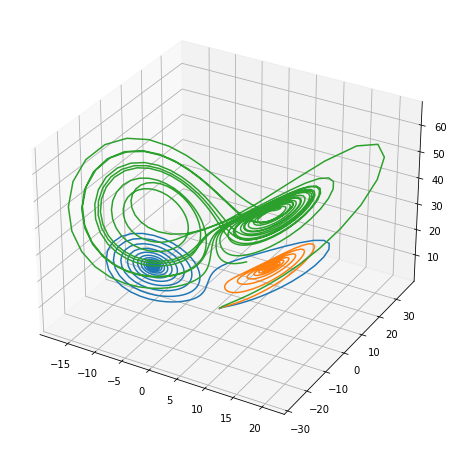

In [43]:
plot_models([m1,m2,m3])

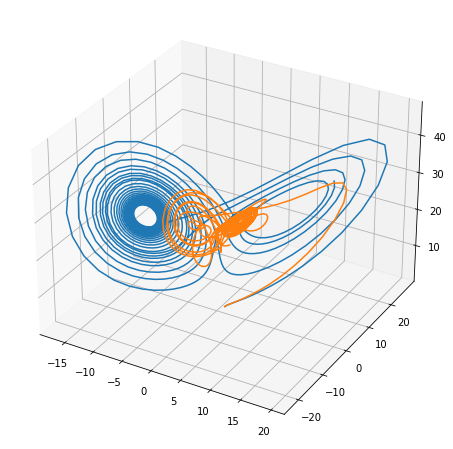

In [143]:
mean_model = calc_mean_lorenz(np.array([m1, m2, m3]))
plot_models([lorenz_attr, mean_model])

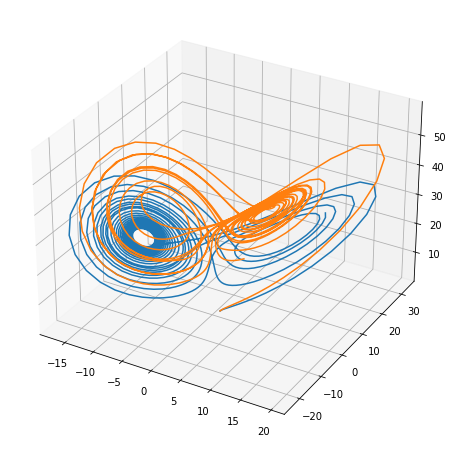

In [190]:
coords_weights = [0.1,0.1,1.1]
weighted_avg_model = calc_weighted_average_lorenz(
    np.array([m1, m2, m3]),
    coords_weights
)

plot_models([lorenz_attr, weighted_avg_model])

8.916666666666666 25.0 2.966666666666667


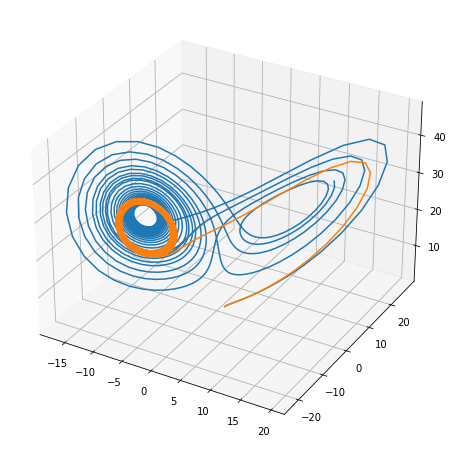

In [193]:
mean_params = calc_mean_params(np.array([
    [model_1_params[p] for p in ['sigma','rho','beta']],
    [model_2_params[p] for p in ['sigma','rho','beta']],
    [model_3_params[p] for p in ['sigma','rho','beta']],
]))

print(*mean_params)
mean_params_lorenz = generate_lorenz(1,1,1,*mean_params)
plot_models([lorenz_attr, mean_params_lorenz])

9.329545454545455 27.5 2.709090909090909


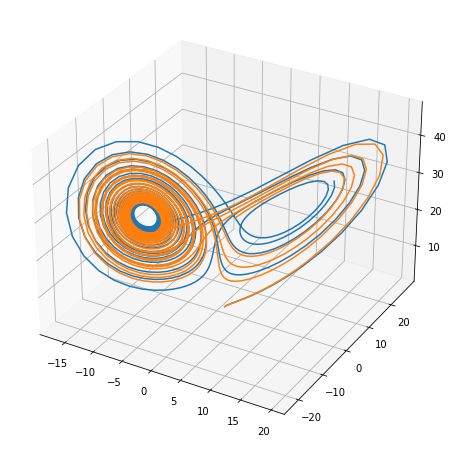

In [192]:
params_weights = [9,3,10]
avg_weighted_params = calc_weighted_average_params(np.array([
    [model_1_params[p] for p in ['sigma','rho','beta']],
    [model_2_params[p] for p in ['sigma','rho','beta']],
    [model_3_params[p] for p in ['sigma','rho','beta']],
]), params_weights)

print(*avg_weighted_params)
avg_weighted_params_lorenz = generate_lorenz(1,1,1,*avg_weighted_params)
plot_models([lorenz_attr, avg_weighted_params_lorenz])